### Predicting individual differences from fMRI data

We will use the data from the Consortium for Neuropsychiatric Phenomics ([Poldrack et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5139672/)) to examine prediction of individual differences from fMRI data.

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
from pathlib import Path
import nilearn
import sklearn
from nilearn.maskers import NiftiMasker
from sklearn.svm import SVC, SVR
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import RidgeCV, SGDClassifier, SGDRegressor
from scipy.stats import ks_2samp
from nilearn.plotting import plot_stat_map
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import einops
from sklearn.preprocessing import OneHotEncoder

device = 'mps'

In [162]:
metadata_df.diagnosis.unique()

array(['SCHZ', 'ADHD', 'BIPOLAR', 'CONTROL'], dtype=object)

### Load the data

In [281]:
basedir = Path('/Users/poldrack/data_unsynced/CNP')
output_dir = basedir / 'output'
if not output_dir.exists():
    output_dir.mkdir()

# load the data
contrast_dict = {
    'stopsignal': {
        "Go": 1,
        "GoRT": 3,
        "StopSuccess": 5,
        "StopUnsuccess": 7,
        "StopUnsuccessRT": 9,
        "Go-StopSuccess": 11,
        "Go-StopUnsuccess": 13,
        "StopSuccess-StopUnsuccess": 15
}   ,
    'scap': {
        "All": 1,
        "All_rt": 3,
        "Load1": 5,
        "Load3": 7,
        "Load5": 9,
        "Load7": 11,
        "Delay1.5": 13,
        "Delay3": 15,
        "Delay4.5": 17,
        "LinearUp_load": 19,
        "LinearUp_delay": 21,
        "Load3-load1": 23,
        "Load5-load1": 25,
        "Load7-load1": 27,
        "Load5-load3": 29,
        "Load7-load3": 31,
        "Load7-load5": 33,
        "Delay4_5-delay1_5": 35,
        "Delay3-delay1_5": 37,
        "Delay4_5-delay3": 39
    },
    'bart': {
        "Accept": 1,
        "AcceptRT": 3,
        "AcceptParametric": 5,
        "Control": 7,
        "Explode": 9,
        "ExplodeParametric": 11,
        "Reject": 13,
        "RejectRT": 15,
        "RejectParametric": 17,
        "AcceptParam-ExplodeParam": 19,
        "AcceptParam-RejectParam": 21,
        "Explode-Reject": 23
     },
    'pamret': {
        "All": 1,
        "All_RT": 3,
        "Correct": 5,
        "Incorrect": 7,
        "TruePos": 9,
        "TrueNeg": 11,
        "FalsePos": 13,
        "FalseNeg": 15,
        "TruePos_RT": 17,
        "TrueNeg_RT": 19,
        "FalsePos_RT": 21,
        "FalseNeg_RT": 23,
        "Control": 25,
        "TruePos-TrueNeg": 27,
        "FalsePos-FalseNeg": 29,
        "TruePos-FalsePos": 31,
        "TrueNeg-FalseNeg": 33,
        "Corr-Incorr": 35,
        "Correct-Control": 37,
        "Incorrect-Control": 39,
        "TruePos-Control": 41,
        "TrueNeg-Control": 43,
        "FalsePos-Control": 45,
        "FalseNeg-Control": 47,
        "All-Control": 49
    },
    'taskswitch': {
        'All': 1,
        'All_RT': 3,
        'CONGRUENT-INCONGRUENT': 37,
        'SWITCH-NOSWITCH': 39,
    }
}

def add_pheno_var(metadata_df, basedir, phenotype, varname):
    participants_file = basedir / 'participants.tsv'
    phenotype_df = pd.read_csv(participants_file, sep='\t')
    if varname not in phenotype_df.columns:
        phenotype_file = basedir / 'phenotype' / f'{phenotype}.tsv'
        phenotype_df = pd.read_csv(phenotype_file, sep='\t')
        if varname not in phenotype_df.columns:
            raise ValueError(f'Variable {varname} not found in either {phenotype_file} or {participants_file}')
    metadata_df[varname] = metadata_df.participant_id.map(phenotype_df.set_index('participant_id')[varname])
    return metadata_df

task = 'pamret'
contrast = 'All'
pheno_var = 'age'

def get_data(basedir, task, cope, pheno_var, 
             patientgroups=None, standardize=True):
    if patientgroups is None:
        patientgroups = ['SCHZ', 'BIPOLAR']
    cope = contrast_dict[task][contrast]
    metadata_df = pd.read_csv(basedir / 'combined' / task / 'metadata.csv')
    metadata_df['patient'] = metadata_df.diagnosis.isin(['SCHZ', 'BIPOLAR']).astype('int')
    #print('proportion of patients:', metadata_df.patient.mean())
    metadata_df = add_pheno_var(metadata_df, basedir, task, pheno_var)
    # print(metadata_df[pheno_var].describe())

    taskdir = basedir / 'combined' / task 
    data_img = nib.load(taskdir/ f'cope{cope}_combat.nii.gz')
    mask_img = nib.load(taskdir / 'mask.nii.gz')
    masker = NiftiMasker(mask_img, standardize=standardize)
    data = masker.fit_transform(data_img)

    # remove subjects with NaN in pheno_var
    if metadata_df[pheno_var].isnull().sum() > 0:
        print(f'removing {metadata_df[pheno_var].isnull().sum()} subjects with missing {pheno_var}')
        data = data[~metadata_df[pheno_var].isnull(), :]
        metadata_df = metadata_df[~metadata_df[pheno_var].isnull()]
        metadata_df = metadata_df.reset_index(drop=True)

    assert metadata_df.shape[0] == data.shape[0]
    return data, metadata_df

data, metadata_df = get_data(basedir, task, contrast, pheno_var,
                             patientgroups = ['SCHZ', 'BIPOLAR', 'ADHD'])

### Continuous prediction is tricky

First let's generate a y variable that we know to be correlated with the fMRI data, and make sure that we can predict it.  We will use a Weibull distribution to generate y values that are slightly skewed, like those in the real data.



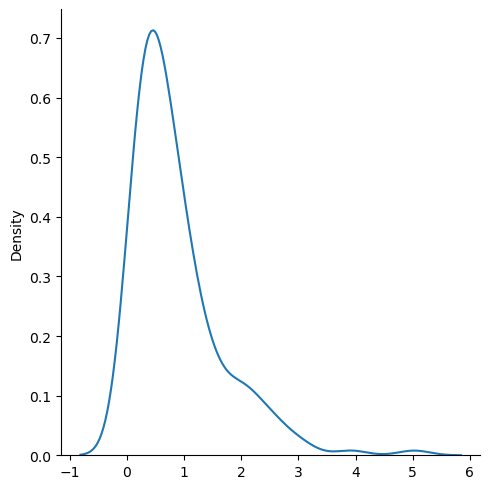

In [315]:
def make_simulated_y(data, snr=0, weib_param=1.1, seed=None):
    rng = np.random.RandomState(seed)
    weights = np.random.randn(data.shape[1])
    y_sim = data.dot(weights) * snr + rng.weibull(weib_param, size=data.shape[0])
    return y_sim

y_sim = make_simulated_y(data, snr=0)
sns.displot(y_sim, kind='kde')


Do ridge regression to see how strong the association is.

In [316]:
def run_ridgeCV(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False,
                clf=None):
    ss = ShuffleSplit(n_splits=nsplits,
                      test_size=test_size, random_state=seed)
    r2 = []
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        train_X = data[train_idx]
        train_y = target[train_idx]
        test_X = data[test_idx]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = RidgeCV
        model = clf()
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        r2.append(sklearn.metrics.r2_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={r2[-1]}')

    return np.mean(r2)

run_ridgeCV(data, y_sim)

np.float64(-0.104560259876129)

Why is the mean r2 negative?

In [331]:

def run_ridgeCV_equaldist(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False, splitmult=10000,
                pthresh=.999, clf=None, shuffle_y=False):
    
    ss = ShuffleSplit(n_splits=nsplits*splitmult,
                      test_size=test_size, random_state=seed)
    r2 = []
    if shuffle_y:
        target = np.random.permutation(target)
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        if ks_2samp(target[train_idx], target[test_idx]).pvalue < pthresh:
            continue
        train_X = data[train_idx]
        train_y = target[train_idx]
        test_X = data[test_idx]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = RidgeCV()
        model = clf
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        r2.append(sklearn.metrics.r2_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={r2[-1]}')
        if len(r2) == nsplits:
            break
    if verbose:
        if len(r2) < nsplits:
            print(f'Warning: only {len(r2)} splits completed on {split_idx} attempts')
        else:
            print(f'Completed {len(r2)} splits on {split_idx} attempts')
    return np.mean(r2)

run_ridgeCV_equaldist(data, y_sim, verbose=True)

split 226: r2=-0.1757612669186075
split 687: r2=-0.05239580097155505
split 1950: r2=-0.16828584005118996
split 2391: r2=-0.2581739524967219
split 2845: r2=-0.029566474424062683
split 3061: r2=-0.007362517964631277
split 3312: r2=-0.05951463666776102
split 4646: r2=-0.058126110042105994
split 5307: r2=-0.08308245347305565
split 5352: r2=-0.23166017616031342
split 6882: r2=-0.003396424278001575
split 7051: r2=-0.13356899345870654
split 9521: r2=-0.09053775958361943
split 10430: r2=-0.04586941868100114
split 11259: r2=-0.1557433769459735
split 11572: r2=-0.12406319718974967
split 11772: r2=0.06415578109459397
split 12011: r2=-0.15416038252996045
split 12064: r2=-0.05316351263110741
split 12442: r2=-0.09802435268111354
split 13561: r2=-0.16600075396238378
split 13660: r2=-0.17327865562419786
split 15163: r2=-0.05184579783603249
split 15421: r2=-0.12944289782013163
split 20086: r2=-0.05722616433830385
split 20595: r2=-0.0383141723101057
split 23579: r2=-0.06203453473921572
split 24596: r2=-

np.float64(-0.09100549354223311)

Now generate some data with true signal and make sure it works.

In [130]:
y_sim = make_simulated_y(data, snr=1)
print(run_ridgeCV(data, y_sim))
run_ridgeCV_equaldist(data, y_sim)

-0.08798785744224638
Completed 100 splits on 95567 attempts


np.float64(-0.06477731493951755)

### Decoding continuous variables across subjects

Let's decode age from the fMRI data.

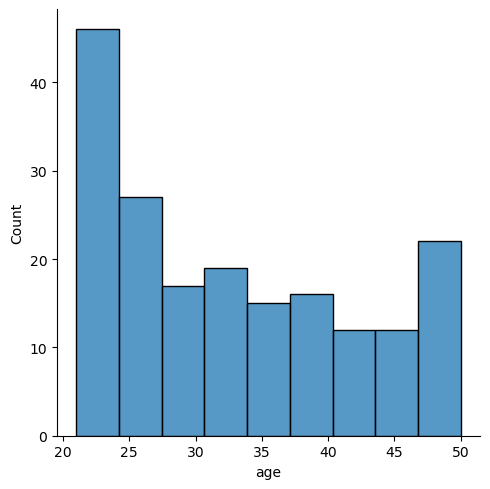

In [282]:
sns.displot(metadata_df[pheno_var])

In [303]:
# use shuffle split

acc = run_ridgeCV_equaldist(data, metadata_df[pheno_var])
print('Mean accuracy:', acc)

shuf_acc = [acc] # include the actual accuracy to preven p=0
for i in range(500):
    shuf_acc.append(run_ridgeCV_equaldist(data, metadata_df[pheno_var], 
                                     shuffle_y=True))
print('p-value under null:', np.mean(acc <= np.array(shuf_acc)))


0.2069118115787831


np.float64(0.0)

### Between-subject classification

patient vs control

Patient classification using stopsignal GoRT: 0.4941846264367816


Text(0, 0.5, 'accuracy')

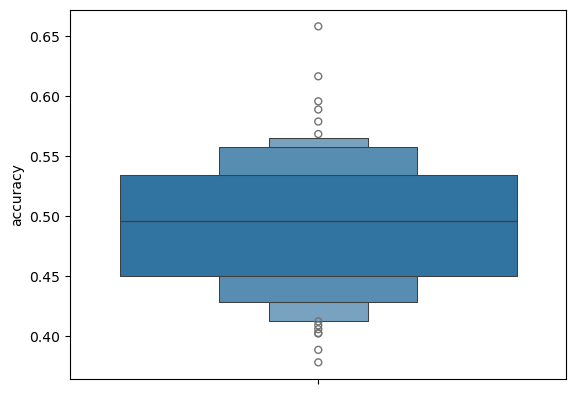

In [272]:
def run_clf_stratified(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False, splitmult=10000,
                pthresh=.9, clf=None, shuffle_y=False):
    
    sss = StratifiedShuffleSplit(n_splits=nsplits*splitmult,
                      test_size=test_size, random_state=seed)
    acc = []
    coefs = None
    for split_idx, (train_idx, test_idx) in enumerate(sss.split(data, target)):
        if shuffle_y:
            target = np.random.permutation(target)
        train_X = data[train_idx]
        train_y = target[train_idx]
        test_X = data[test_idx]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = SGDClassifier
        model = clf()
        model.fit(train_X, train_y)
        if coefs is None:
            coefs = model.coef_
        else:
            coefs += model.coef_
        pred_y = model.predict(test_X)
        acc.append(sklearn.metrics.balanced_accuracy_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={acc[-1]}')
        if len(acc) == nsplits:
            break
    coefs /= (split_idx + 1)
    return acc, coefs

acc, _ = run_clf_stratified(data, metadata_df.patient)
print(f'Patient classification using {task} {contrast}: {np.mean(acc)}')
sns.boxenplot(acc)
plt.ylabel('accuracy')


In [278]:
accs = []

for task in ['stopsignal', 'scap', 'bart']:
    taskdir = basedir / 'combined' / task 
    copefiles = list(taskdir.glob('cope*.nii.gz'))
    for contrast in contrast_dict[task].keys():
        try:
            data, metadata_df = get_data(basedir, task, contrast, pheno_var,
                                        patientgroups = ['SCHZ', 'BIPOLAR'])
            acc, _ = run_clf_stratified(data, metadata_df.patient, nsplits = 100)
            shuffle_acc, _ = run_clf_stratified(data, metadata_df.patient,
                                            shuffle_y=True, nsplits=1000)
            pval = np.mean(np.mean(acc) < shuffle_acc)
            print(f'Patient classification using {task} {contrast}: {np.mean(acc):.3f} (p = {pval:.3f})')
            accs.append([task, contrast, np.mean(acc),  pval])
            print('')
        except Exception as e:
            print(f'Error on {task} {contrast}: {e}')
            continue


Patient classification using stopsignal Go: 0.506 (p = 0.443)

Patient classification using stopsignal GoRT: 0.477 (p = 0.693)

Patient classification using stopsignal StopSuccess: 0.481 (p = 0.651)

Patient classification using stopsignal StopUnsuccess: 0.461 (p = 0.809)

Patient classification using stopsignal StopUnsuccessRT: 0.510 (p = 0.416)



KeyboardInterrupt: 

### Predict using a nonlinear model

There may be some nonlinear signals, so let's try a neural network.

In [135]:
from CNNModel import CNNModel

model = CNNModel(
    input_shape=[1],
    out_shape=data_img.get_fdata().shape[:3],
    num_classes=2
)

model.to(device)
print(model)

CNNModel(
  (model): Sequential(
    (0): Conv3d(1, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout3d(p=0.1, inplace=False)
    (4): Conv3d(8, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2))
    (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout3d(p=0.1, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=19040, out_features=2, bias=True)
  )
)


In [136]:
def get_dataloaders(train_idx, test_idx, data_img, labels, batch_size=20):
    data = einops.rearrange(data_img.get_fdata(), 'x y z s -> s 1 x y z')
    data_tensor = torch.tensor(in_data.astype('float32')).to(device).to(torch.float32)
    enc = OneHotEncoder(handle_unknown='ignore')
    labels = np.array(labels).reshape(-1, 1)
    labels_tensor = torch.tensor(enc.fit_transform(labels).toarray().astype('float32')).to(device).to(torch.float32)

    Dataset_train = TensorDataset(data_tensor[train_idx], labels_tensor[train_idx])
    Loader_train = DataLoader(Dataset_train, batch_size=batch_size, shuffle=True)

    Dataset_test = TensorDataset(data_tensor[test_idx], labels_tensor[test_idx])
    Loader_test = DataLoader(Dataset_test, batch_size=batch_size, shuffle=True)
    return Loader_train, Loader_test

Loader_train, Loader_test = get_dataloaders([1,2,3], [4,5,6], data_img, metadata_df.patient)
print(Loader_train.dataset.tensors[0].shape)
Loader_train.dataset.tensors[1].shape



torch.Size([3, 1, 65, 77, 49])


torch.Size([3, 2])

In [137]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    lossvals = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        lossvals.append(loss.detach().cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(lossvals)



def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    lossvals = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            lossvals.append(loss.detach().cpu().item())
            predresp = pred.argmax(1)
            correct += (predresp == y.argmax(1)).type(torch.float).sum().item()
            #correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return np.mean(lossvals), correct




In [138]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
        model.parameters(),
        lr=.01
    )
nepochs = 100

ss = ShuffleSplit(n_splits=1, test_size=.2, random_state=None)

train_loss = []
test_loss = []
test_correct = []

for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):

    for epoch in range(nepochs):
        Loader_train, Loader_test = get_dataloaders(
            train_idx, test_idx, data_img, metadata_df.patient.values)

        train_loss.append(train_loop(Loader_train, model, loss_fn, optimizer))
        t_loss, t_corr = test_loop(Loader_test, model, loss_fn)
        test_loss.append(t_loss)
        test_correct.append(t_corr)
    


Text(0.5, 0, 'epoch')

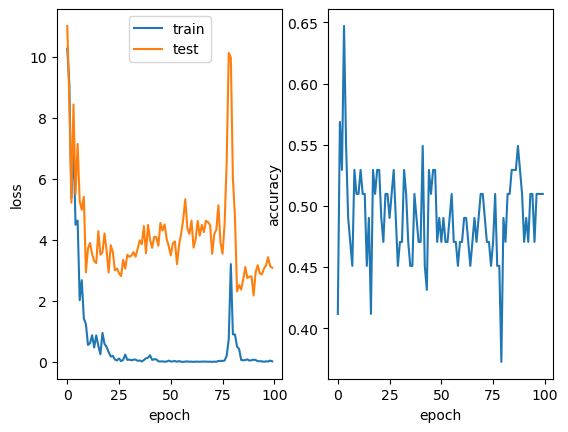

In [139]:
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(test_correct)
plt.ylabel('accuracy')
plt.xlabel('epoch')


In [140]:
test_correct

[0.4117647058823529,
 0.5686274509803921,
 0.5294117647058824,
 0.6470588235294118,
 0.5490196078431373,
 0.49019607843137253,
 0.47058823529411764,
 0.45098039215686275,
 0.5294117647058824,
 0.5098039215686274,
 0.5098039215686274,
 0.5294117647058824,
 0.5098039215686274,
 0.5098039215686274,
 0.45098039215686275,
 0.49019607843137253,
 0.4117647058823529,
 0.5294117647058824,
 0.5098039215686274,
 0.5294117647058824,
 0.5294117647058824,
 0.49019607843137253,
 0.47058823529411764,
 0.5098039215686274,
 0.5098039215686274,
 0.49019607843137253,
 0.5098039215686274,
 0.5294117647058824,
 0.49019607843137253,
 0.45098039215686275,
 0.47058823529411764,
 0.47058823529411764,
 0.5294117647058824,
 0.5098039215686274,
 0.47058823529411764,
 0.45098039215686275,
 0.45098039215686275,
 0.5098039215686274,
 0.49019607843137253,
 0.47058823529411764,
 0.47058823529411764,
 0.5490196078431373,
 0.45098039215686275,
 0.43137254901960786,
 0.5294117647058824,
 0.5098039215686274,
 0.52941176470